# MCMC – Implementierung mit `emcee`

vgl. https://prappleizer.github.io/Tutorials/MCMC/MCMC_Tutorial.html

## Installs

In [1]:
# !pip install emcee
# !pip install corner

## Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# neue Bibliotheken:
import emcee
import corner

## Parameter für Zeichenfläche

In [3]:
plt.rcParams['figure.figsize'] = (20,10)

## Daten einlesen und explorieren

In [4]:
ice_data = pd.read_csv("https://raw.githubusercontent.com/johlei/introduction-to-mcmc/main/ice-cores.csv", sep=";")
print(ice_data.head())
print(ice_data.tail())

        age  temperature_deviation
0  38.37379                   0.88
1  46.81203                   1.84
2  55.05624                   3.04
3  64.41511                   0.35
4  73.15077                  -0.42
           age  temperature_deviation
5783  797408.0                  -8.73
5784  798443.0                  -8.54
5785  799501.0                  -8.88
5786  800589.0                  -8.92
5787  801662.0                  -8.82


In [5]:
age = ice_data["age"]
T = ice_data["temperature_deviation"]

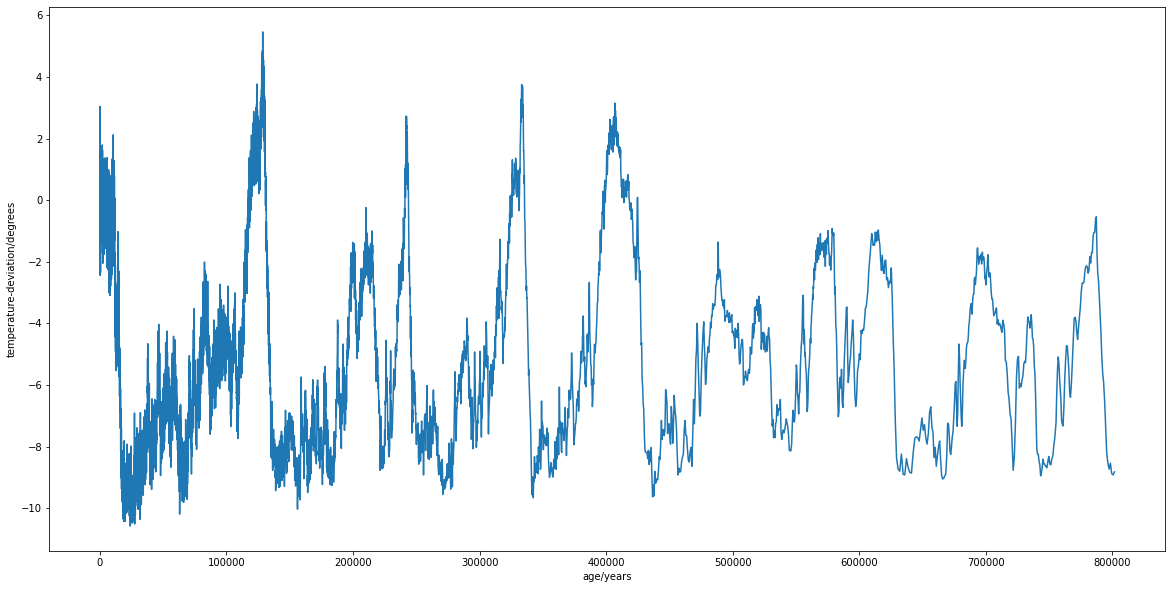

In [25]:
plt.plot(age, T)
plt.xlabel("age/years")
plt.ylabel("temperature-deviation/degrees")
plt.show()

## Funktionen für MCMC

In [7]:
def model(theta, age=age):
    a1,a2,a3,p1,p2,p3,T0 = theta
    return a1*np.sin(2*np.pi*age/p1) + a2*np.sin(2*np.pi*age/p2) + a3*np.sin(2*np.pi*age/p3) + T0

In [8]:
def lnlike(theta, x, y, yerr):
    return -0.5 * np.sum(((y - model(theta, x))/yerr) ** 2)

In [9]:
def lnprior(theta):
    a1, a2, a3, p1, p2, p3, T0 = theta
    if 0.0 < a1 < 5.0 and 0.0 < a2 < 5.0 and 0.0 < a3 < 5.0 and 10000. < p1 < 200000 and 10000. < p2 < 200000 and 10000. < p3 < 200000 and -10.0 < T0 < 0:
        return 0.0
    return -np.inf

In [10]:
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

In [11]:
def plotter(sampler,age=age,T=T):
    plt.plot(age,T,label='Change in T')
    samples = sampler.flatchain
    for theta in samples[np.random.randint(len(samples), size=100)]:
        plt.plot(age, model(theta, age), color="r", alpha=0.1)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.xlabel('Years ago')
    plt.ylabel(r'$\Delta$ T (degrees)')
    plt.legend()
    plt.rcParams['figure.figsize'] = (20,10)
    plt.show()

In [12]:
def main(p0,nwalkers,niter,ndim,lnprob,data):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data)

    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, 100)
    sampler.reset()

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter)

    return sampler, pos, prob, state

## Variablen für Durchlauf

In [13]:
Terr = 0.05*np.mean(T)
data = (age, T, Terr)
nwalkers = 128
niter = 500
initial = np.array([1.0, 1.0, 1.0, 26000., 41000.,100000.,-4.5])
ndim = len(initial)
p0 = [np.array(initial) + 1e-7 * np.random.randn(ndim) for i in range(nwalkers)]

## Starte Iterationen

In [14]:
sampler, pos, prob, state = main(p0, nwalkers, niter, ndim, lnprob, data)

Running burn-in...
Running production...


## Plotte Ergebnisse

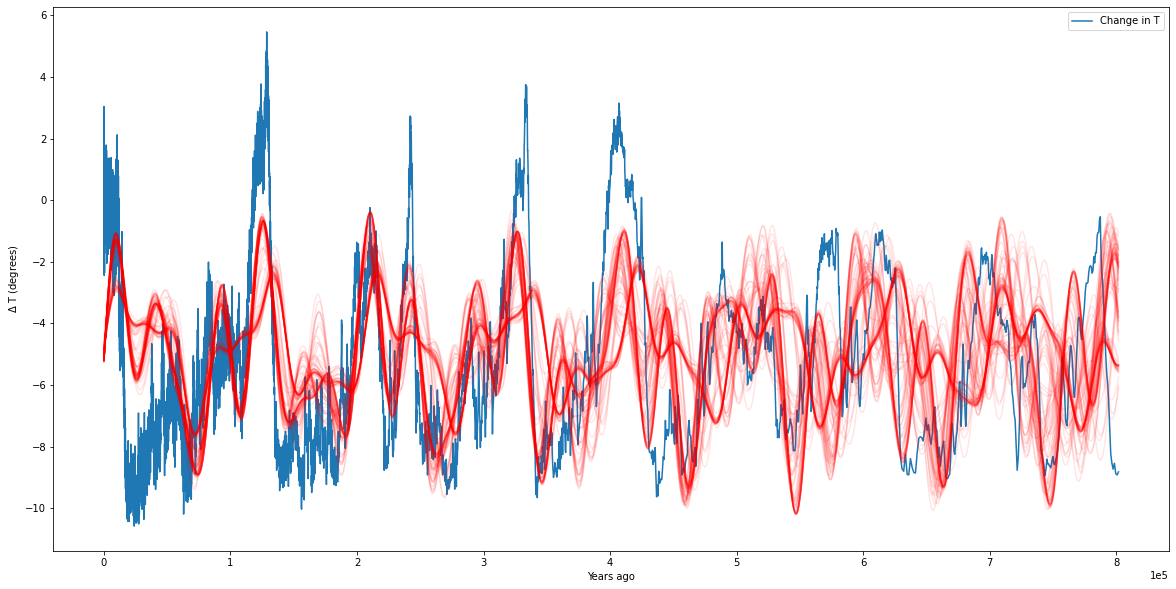

In [24]:
plotter(sampler)

## Parameter mit höchster Likelihood

In [16]:
samples = sampler.flatchain
samples[np.argmax(sampler.flatlnprobability)]

array([ 1.20203444e+00,  2.03138962e+00,  1.82648268e+00,  2.91348093e+04,
        3.97629092e+04,  9.60247690e+04, -5.24218302e+00])

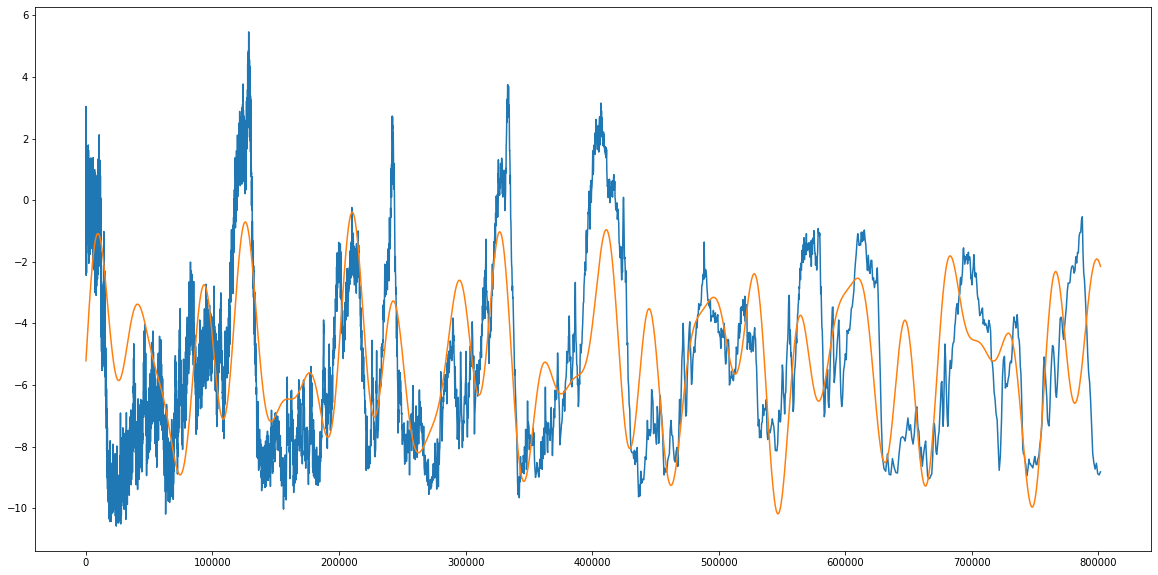

Theta max:  [ 1.20203444e+00  2.03138962e+00  1.82648268e+00  2.91348093e+04
  3.97629092e+04  9.60247690e+04 -5.24218302e+00]


In [17]:
theta_max  = samples[np.argmax(sampler.flatlnprobability)]
best_fit_model = model(theta_max)
plt.plot(age, T, label='Change in T')
plt.plot(age, best_fit_model, label='Highest Likelihood Model')
plt.show()
print('Theta max: ', theta_max)

## Posterior Spread

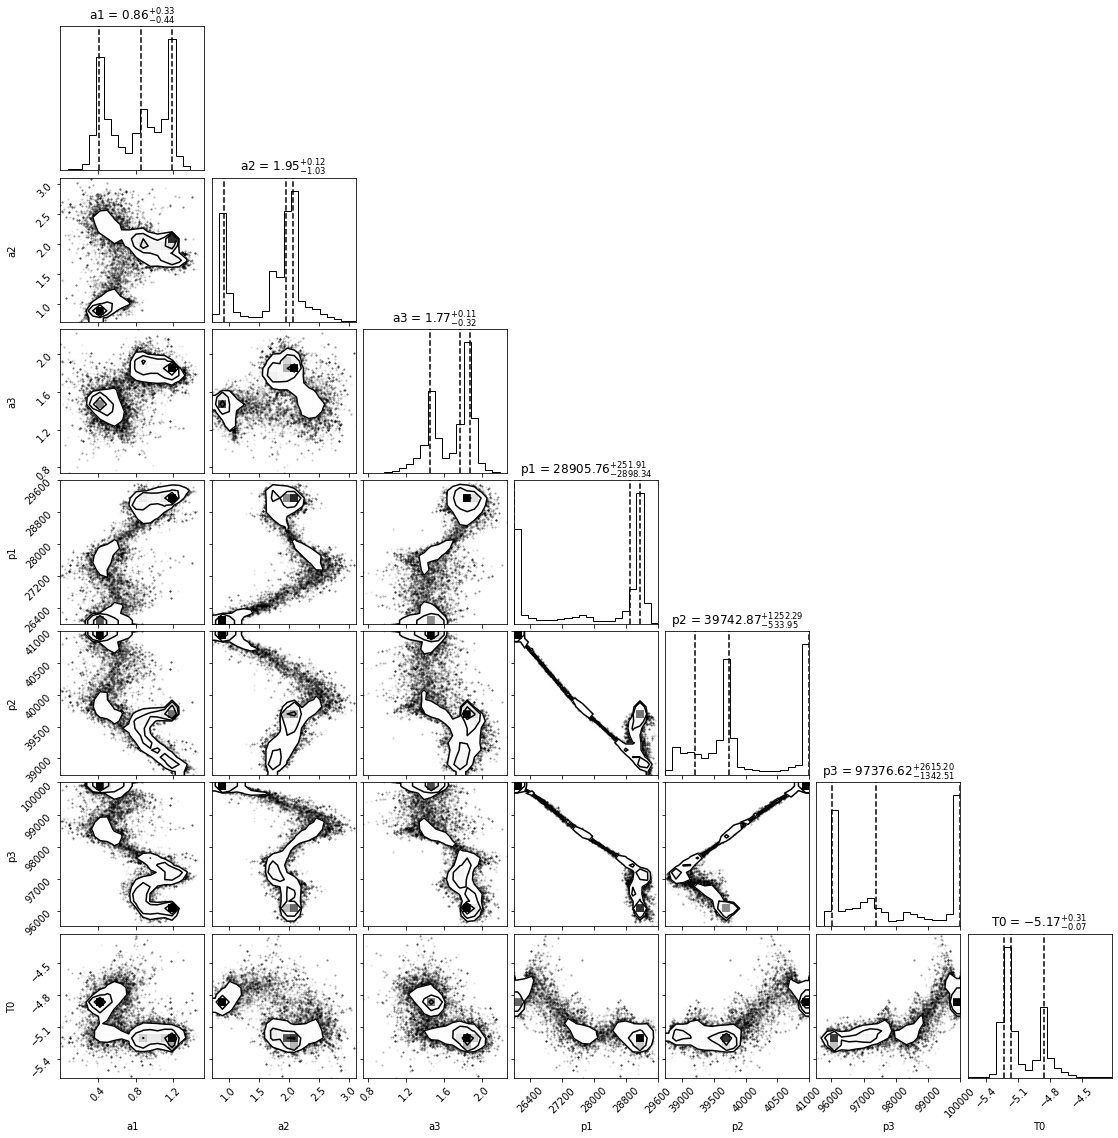

In [18]:
labels = ['a1','a2','a3','p1','p2','p3','T0']
fig = corner.corner(samples, show_titles=True, labels=labels, plot_datapoints=True, quantiles=[0.16, 0.5, 0.84])

In [19]:
Terr = 0.05*np.mean(T)
data = (age, T,Terr)
nwalkers = 240 # größere Anzahl an parallel laufenden Berechnungen
niter = 1024 # größere Anzahl an Durchläufen
initial = np.array([1.0, 1.0, 1.0, 26000., 41000., 100000., -4.5])
ndim = len(initial)
p0 = [np.array(initial) + 1e-7 * np.random.randn(ndim) for i in range(nwalkers)]

In [20]:
new_sampler, newpos, newprob, newstate = main(p0,nwalkers,niter,ndim,lnprob,data)

Running burn-in...
Running production...


In [21]:
new_samples = new_sampler.flatchain

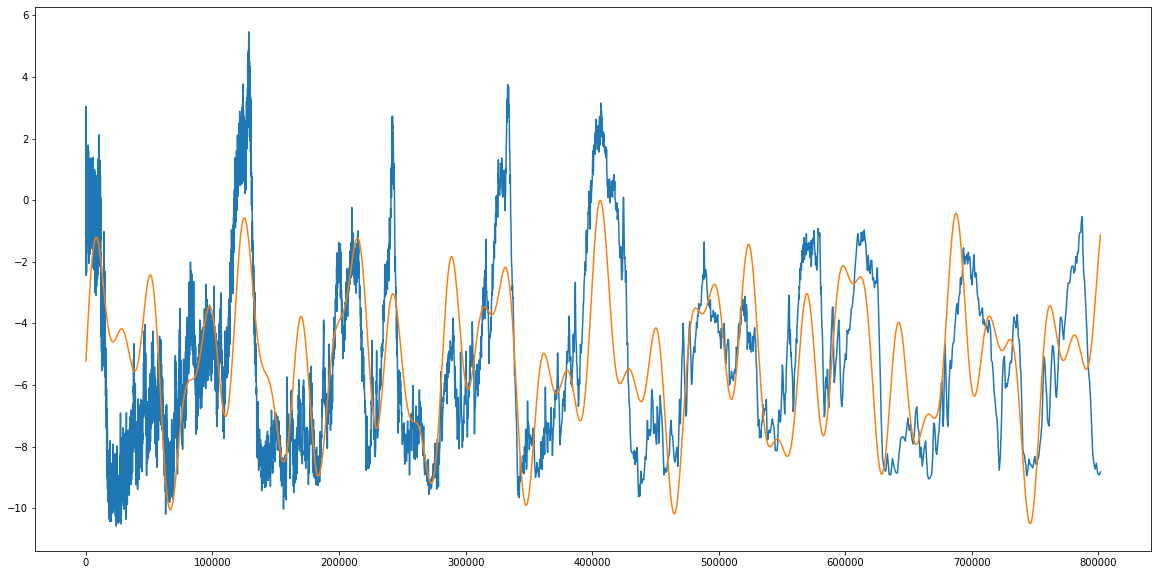

Theta max:  [ 1.32760011e+00  2.07866299e+00  1.89801301e+00  2.35211352e+04
  3.97331046e+04  9.61353299e+04 -5.25691930e+00]


In [22]:
new_theta_max  = new_samples[np.argmax(new_sampler.flatlnprobability)]
new_best_fit_model = model(new_theta_max)
plt.plot(age,T,label='Change in T')
plt.plot(age,new_best_fit_model,label='Highest Likelihood Model')
plt.show()
print('Theta max: ',new_theta_max)

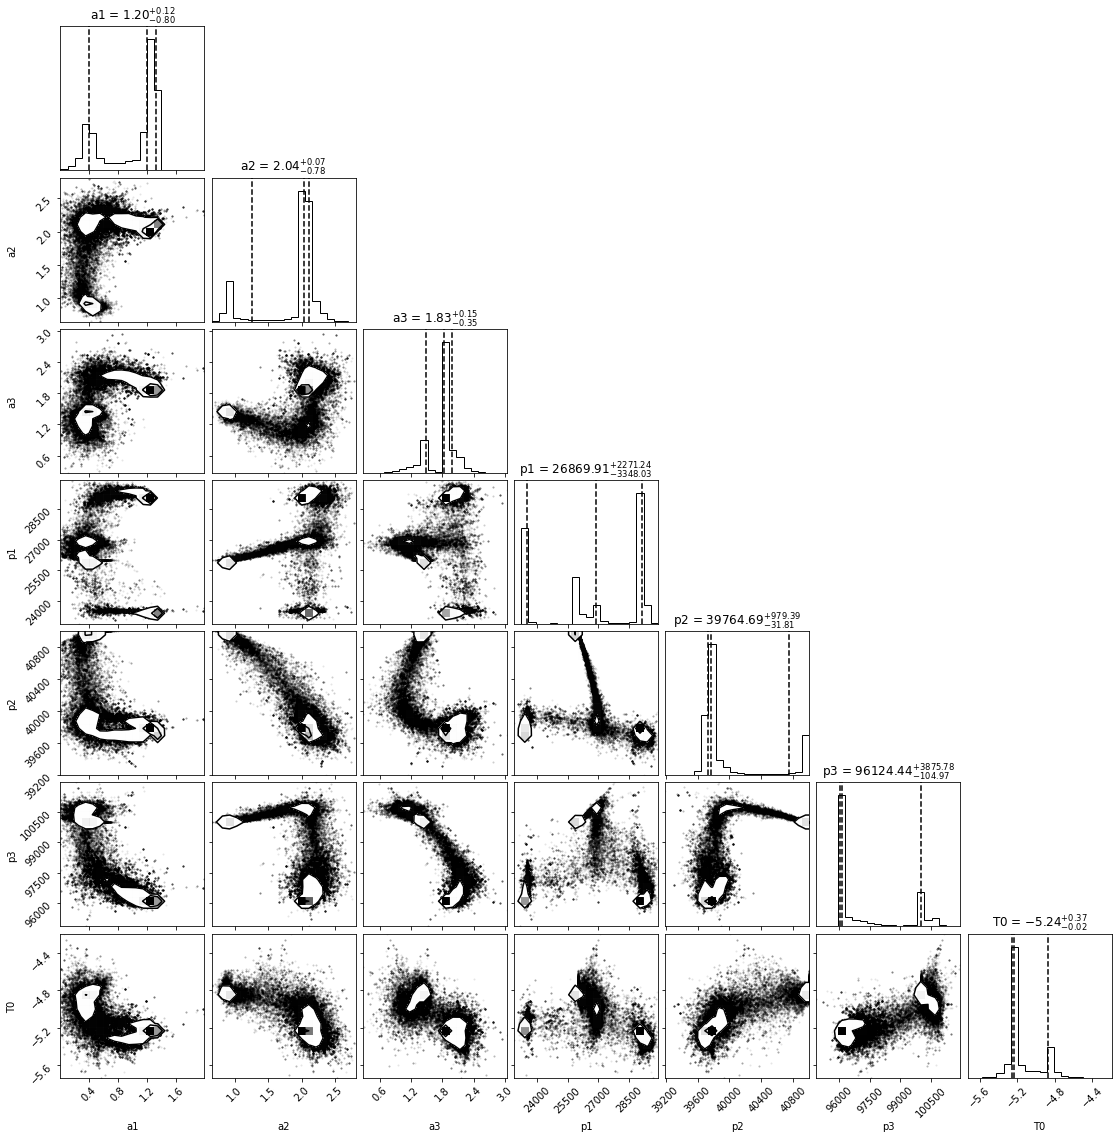

In [23]:
labels = ['a1','a2','a3','p1','p2','p3','T0']
fig = corner.corner(new_samples,show_titles=True,labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84])